In [4]:
import pandas as pd
import numpy as np
import re
import string
from sklearn import preprocessing
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import plotly.graph_objs as go
import plotly.offline as py
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import iplot
from collections import defaultdict
from sklearn.decomposition import PCA
from wordcloud import WordCloud, STOPWORDS
import pandas as pd 
import numpy as np 
import nltk
import re
import string
from wordcloud import STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn 
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from sklearn import svm, datasets
from sklearn import preprocessing 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy import interp
from itertools import cycle
import cufflinks as cf
from collections import Counter


In [5]:
raw_reviews = pd.read_csv(r'Musical_instruments_reviews.csv')
print ("The shape of the  data is (row, column):"+ str(raw_reviews.shape))
print (raw_reviews.info())

The shape of the  data is (row, column):(10261, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB
None


In [6]:
raw_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]   
1                                              Jake  [13, 14]   
2                     Rick Bennette "Rick Bennette"    [1, 1]   
3                         RustyBill "Sunday Rocker"    [0, 0]   
4                                     SEAN MASLANKA    [0, 0]   

                                          reviewText  overall  \
0  Not much to write about here, but it does exac...      5.0   
1  The product does exactly as it should and is q...      5.0   
2  The primary job of this device is to block the...      5.0   
3  Nice windscreen protects my MXL mic and preven...      5.0   
4  This pop filter is great. It looks and perform...      5.0   

                                 summary  unixReviewTime   reviewTime  
0                                   good      1393545600  02 28, 2014  
1                                   Jake      1363392000  03 16, 2013  
2                   It Does The Job Well      1377648000  08 28, 2013  
3          GOOD WINDSCREEN FOR THE MONEY      1392336000  02 14, 2014  
4  No more pops when I record my vocals.      1392940800  02 21, 2014

缺失值的查找与处理

In [7]:
#Creating a copy
process_reviews=raw_reviews.copy()
#Checking for null values
process_reviews.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

In [8]:
process_reviews['reviewText']=process_reviews['reviewText'].fillna('Missing')

In [9]:
# 创建新列
process_reviews['reviews'] = process_reviews['reviewText'] + process_reviews['summary']
# 删除原始列
process_reviews = process_reviews.drop(['reviewText', 'summary'], axis=1)
# 显示修改后的数据框的前几行
print(process_reviews.head())

       reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime   reviewTime  \
0      1393545600  02 28, 2014   
1      1363392000  03 16, 2013   
2      1377648000  08 28, 2013   
3      1392336000  02 14, 2014   
4      1392940800  02 21, 2014   

                                             reviews  
0  Not much to write about here, but it does exac...  
1  The product does exactly as it should 

根据总分决定结果列（评论情绪）。如果分数大于 3，我们将其视为正数，如果该值小于 3，则为负数，如果分数等于 3，我们将其视为中性情绪


In [10]:
process_reviews['overall'].value_counts()

5.0    6938
4.0    2084
3.0     772
2.0     250
1.0     217
Name: overall, dtype: int64

In [11]:
def f(row):
    if row['overall'] == 3.0:
        val = 'Neutral'
    elif row['overall'] == 1.0 or row['overall'] == 2.0:
        val = 'Negative'
    elif row['overall'] == 4.0 or row['overall'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [12]:
process_reviews['sentiment'] = process_reviews.apply(f, axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime   reviewTime  \
0      1393545600  02 28, 2014   
1      1363392000  03 16, 2013   
2      1377648000  08 28, 2013   
3      1392336000  02 14, 2014   
4      1392940800  02 21, 2014   

                                             reviews sentiment  
0  Not much to write about here, but it does exac...  Positive  
1  The product does exactly as it should and is q...  Positive  
2  The primary job of this device is to block the...  Positive  
3  Nice windscreen protects my MXL mic and preven...  Positive  
4  This pop filter is great. It looks and perform...  Positive

In [13]:
process_reviews['sentiment'].value_counts()

Positive    9022
Neutral      772
Negative     467
Name: sentiment, dtype: int64

In [14]:
#Filtering data
review_pos = process_reviews[process_reviews["sentiment"]=='Positive'].dropna()
review_neu = process_reviews[process_reviews["sentiment"]=='Neutral'].dropna()
review_neg = process_reviews[process_reviews["sentiment"]=='Negative'].dropna()

In [15]:
print("Number of positive reviews:", len(review_pos))
print("Number of neutral reviews:", len(review_neu))
print("Number of negative reviews:", len(review_neg))

# 或者检查 DataFrame 的前几行数据
print("Positive reviews sample:")
print(review_pos.head())

print("Neutral reviews sample:")
print(review_neu.head())

print("Negative reviews sample:")
print(review_neg.head())


Number of positive reviews: 8998
Number of neutral reviews: 771
Number of negative reviews: 465
Positive reviews sample:
       reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime   reviewTime  \
0      1393545600  02 28, 2014   
1      1363392000  03 16, 2013   
2      1377648000  08 28, 2013   
3      1392336000  02 14, 2014   
4      1392940800  02 21, 2014   

                              

将日期进一步拆分为月份和日期。

In [16]:
new = process_reviews["reviewTime"].str.split(",", n = 1, expand = True) 
process_reviews["date"]= new[0] 
process_reviews["year"]= new[1] 
process_reviews=process_reviews.drop(['reviewTime'], axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime                                            reviews  \
0      1393545600  Not much to write about here, but it does exac...   
1      1363392000  The product does exactly as it should and is q...   
2      1377648000  The primary job of this device is to block the...   
3      1392336000  Nice windscreen protects my MXL mic and preven...   
4      1392940800  This pop filter is great. It looks and perform...   

  sentiment   date   year  
0  Positive  02 28   2014  
1  Positive  03 16   2013  
2  Positive  08 28   2013  
3  Positive  02 14   2014  
4  Positive  02 21   2014

In [17]:
# 拆分data
new1 = process_reviews["date"].str.split(" ", n = 1, expand = True) 
#月份
process_reviews["month"]= new1[0]   
#日期
process_reviews["day"]= new1[1] 
process_reviews=process_reviews.drop(['date'], axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime                                            reviews  \
0      1393545600  Not much to write about here, but it does exac...   
1      1363392000  The product does exactly as it should and is q...   
2      1377648000  The primary job of this device is to block the...   
3      1392336000  Nice windscreen protects my MXL mic and preven...   
4      1392940800  This pop filter is great. It looks and perform...   

  sentiment   year month day  
0  Positive   2014    02  28  
1  Positive   2013    03  16  
2  Positive   2013    08  28  
3  Positive   2014    02  14  
4  Positive   2014    02  21

评论的有用性

In [18]:
# 使用逗号和方括号将 helpful 列中的字符串拆分成两个子列 new1
new1 = process_reviews["helpful"].str.split(",", n=1, expand=True)
# 对 new1 的第一个子列进行进一步拆分，以去除方括号，得到 new2
new2 = new1[0].str.split("[", n=1, expand=True)
# 对 new1 的第二个子列进行进一步拆分，以去除方括号，得到 new3
new3 = new1[1].str.split("]", n=1, expand=True)

# 重置 new2 和 new3 的索引，以确保与其他数据对齐
new2.reset_index(drop=True, inplace=True)
new3.reset_index(drop=True, inplace=True)

# 删除由于拆分而产生的空列
new2 = new2.drop([0], axis=1)
new3 = new3.drop([1], axis=1)

# 将 new2 和 new3 连接起来，形成名为 helpful 的新数据框
helpful = pd.concat([new2, new3], axis=1)

# 创建一个函数 trim_all_columns()，用于去除数据框中所有列值两端的空格
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.applymap(trim_strings)

# 将该函数应用于 helpful 数据框
helpful = trim_all_columns(helpful)

# 将 helpful 数据框中的两列转换为整数类型
helpful[0] = helpful[0].astype(str).astype(int)
helpful[1] = helpful[1].astype(str).astype(int)

# 计算 helpful 数据框中两列的比率，并将结果存储在新列 result 中。在除法过程中，如果遇到分母为零的情况，则将结果设置为 0
try:
    helpful['result'] = helpful[1] / helpful[0]
except ZeroDivisionError:
    helpful['result'] = 0

# 将 result 列中的 NaN 值填充为 0
helpful['result'] = helpful['result'].fillna(0)

# 将 result 列中的值四舍五入到两位小数
helpful['result'] = helpful['result'].round(2)

# 将 result 列的值附加到 process_reviews 数据框中，形成名为 helpful_rate 的新列
process_reviews['helpful_rate'] = helpful['result']

# 从 process_reviews 数据框中删除原始的 helpful 列，因为它已经不再需要
process_reviews = process_reviews.drop(['helpful'], axis=1)


In [19]:
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName  overall  unixReviewTime  \
0  cassandra tu "Yeah, well, that's just like, u...      5.0      1393545600   
1                                              Jake      5.0      1363392000   
2                     Rick Bennette "Rick Bennette"      5.0      1377648000   
3                         RustyBill "Sunday Rocker"      5.0      1392336000   
4                                     SEAN MASLANKA      5.0      1392940800   

                                             reviews sentiment   year month  \
0  Not much to write about here, but it does exac...  Positive   2014    02   
1  The product does exactly as it should and is q...  Positive   2013    03   
2  The primary job of this device is to block the...  Positive   2013    08   
3  Nice windscreen protects my MXL mic and preven...  Positive   2014    02   
4  This pop filter is great. It looks and perform...  Positive   2014    02   

  day  helpful_rate  
0  28          0.00  
1  16          0.93  
2  28          1.00  
3  14          0.00  
4  21          0.00

In [20]:
process_reviews['helpful_rate'].value_counts()
#0.00表示审查没有多大帮助，1.00表示审查非常有帮助

0.00    7215
1.00    2040
0.50     266
0.67     136
0.75     111
        ... 
0.56       1
0.15       1
0.13       1
0.43       1
0.69       1
Name: helpful_rate, Length: 65, dtype: int64

文本的标点处理

In [21]:
process_reviews=process_reviews.drop(['reviewerName','unixReviewTime'], axis=1)
clean_reviews=process_reviews.copy()

In [22]:
def review_cleaning(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [23]:
process_reviews['reviews']=process_reviews['reviews'].apply(lambda x:review_cleaning(x))
process_reviews.head()

reviewerID        asin  overall  \
0  A2IBPI20UZIR0U  1384719342      5.0   
1  A14VAT5EAX3D9S  1384719342      5.0   
2  A195EZSQDW3E21  1384719342      5.0   
3  A2C00NNG1ZQQG2  1384719342      5.0   
4   A94QU4C90B1AX  1384719342      5.0   

                                             reviews sentiment   year month  \
0  not much to write about here but it does exact...  Positive   2014    02   
1  the product does exactly as it should and is q...  Positive   2013    03   
2  the primary job of this device is to block the...  Positive   2013    08   
3  nice windscreen protects my mxl mic and preven...  Positive   2014    02   
4  this pop filter is great it looks and performs...  Positive   2014    02   

  day  helpful_rate  
0  28          0.00  
1  16          0.93  
2  28          1.00  
3  14          0.00  
4  21          0.00

停用词的处理——去掉负面情绪的选择

In [24]:
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each', 
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above', 
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't", 
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from', 
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs', 
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

In [25]:
process_reviews['reviews'] = process_reviews['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
process_reviews.head()

reviewerID        asin  overall  \
0  A2IBPI20UZIR0U  1384719342      5.0   
1  A14VAT5EAX3D9S  1384719342      5.0   
2  A195EZSQDW3E21  1384719342      5.0   
3  A2C00NNG1ZQQG2  1384719342      5.0   
4   A94QU4C90B1AX  1384719342      5.0   

                                             reviews sentiment   year month  \
0  not much write but exactly supposed filters po...  Positive   2014    02   
1  product exactly quite affordablei not realized...  Positive   2013    03   
2  primary job device block breath would otherwis...  Positive   2013    08   
3  nice windscreen protects mxl mic prevents pops...  Positive   2014    02   
4  pop filter great looks performs like studio fi...  Positive   2014    02   

  day  helpful_rate  
0  28          0.00  
1  16          0.93  
2  28          1.00  
3  14          0.00  
4  21          0.00

从预处理过的评论中提取要素


In [26]:
# 创建一个 LabelEncoder 对象
label_encoder = preprocessing.LabelEncoder()
# 使用 LabelEncoder 对情感标签进行整数编码，并将结果存储到 sentiment 列中
process_reviews['sentiment'] = label_encoder.fit_transform(process_reviews['sentiment'])
# 显示经过编码后的情感标签的唯一值
process_reviews['sentiment'].unique()

array([2, 1, 0])

In [27]:
process_reviews['sentiment'].value_counts()

2    9022
1     772
0     467
Name: sentiment, dtype: int64

词干处理
（去掉词缀转换为词根）

In [28]:
review_features=process_reviews.copy()
review_features=review_features[['reviews']].reset_index(drop=True)
review_features.head()

reviews
0  not much write but exactly supposed filters po...
1  product exactly quite affordablei not realized...
2  primary job device block breath would otherwis...
3  nice windscreen protects mxl mic prevents pops...
4  pop filter great looks performs like studio fi...

In [29]:
# 创建一个 PorterStemmer 对象
ps = PorterStemmer()

# 初始化一个空列表用于存储处理后的文本
corpus = []

# 对 review_features 数据集中的每一条评论进行处理
for i in range(0, len(review_features)):
    # 去除非字母字符，并将所有字母转换为小写
    review = re.sub('[^a-zA-Z]', ' ', review_features['reviews'][i])
    # 将评论文本分割成单词列表
    review = review.split()
    # 对每个单词进行词干提取，并过滤掉停用词
    review = [ps.stem(word) for word in review if not word in stop_words]
    # 将处理后的单词列表组合成一个字符串
    review = ' '.join(review)
    # 将处理后的文本添加到语料库中
    corpus.append(review)


In [30]:
corpus[3]

'nice windscreen protect mxl mic prevent pop thing gooseneck margin abl hold screen posit requir care posit clamp avoid sagginggood windscreen money'

TFIDF 量化单词
（将其拆分为bigram（两个单词），并考虑它们的组合权重。此外，我们只从评论中选取前5000个单词。）

In [31]:
# 创建一个 TF-IDF 向量化器，设置最大特征数量为 5000，并设置 n-gram 范围为 (2, 2)，表示只考虑二元（两个单词组成的）词组
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(2, 2))
# 使用 TF-IDF 向量化器对评论文本进行转换，并将结果存储在特征矩阵 X 中
X = tfidf_vectorizer.fit_transform(review_features['reviews'])


In [32]:
X.shape

(10261, 5000)

In [33]:
# 获取目标变量，即情感标签的整数编码，存储在变量 y 中
y = process_reviews['sentiment']


处理不平衡目标特性-SMOTE


与消极和中立相比，我们得到了很多积极的情绪。因此，在这种情况下，平衡阶级是至关重要的。在这里，我使用SMOTE（合成少数过采样技术）来平衡不平衡的数据集问题。它旨在通过复制少数族裔的例子来随机增加，从而平衡阶级分布。

In [34]:
# 打印原始数据集的分布情况
print(f'原始数据集形状: {Counter(y)}')
# 使用 SMOTE 对数据进行过采样
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
# 打印过采样后数据集的分布情况
print(f'过采样后数据集形状: {Counter(y_res)}')

原始数据集形状: Counter({2: 9022, 1: 772, 0: 467})
过采样后数据集形状: Counter({2: 9022, 1: 9022, 0: 9022})


拆分数据集


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=0)

为文本分析创建更多功能
现在，让我们创建极性、复习长度和字数
极性：我们使用Textblob来计算情绪的比率。它介于[-1,1]之间，其中-1为负极，1为正极
评审长度：评审的长度，包括每个字母和空格
单词长度：这衡量了复习中的单词数量

In [36]:
process_reviews['polarity'] = process_reviews['reviews'].map(lambda text: TextBlob(text).sentiment.polarity)
process_reviews['review_len'] = process_reviews['reviews'].astype(str).apply(len)
process_reviews['word_count'] = process_reviews['reviews'].apply(lambda x: len(str(x).split()))

In [37]:
process_reviews.head()

reviewerID        asin  overall  \
0  A2IBPI20UZIR0U  1384719342      5.0   
1  A14VAT5EAX3D9S  1384719342      5.0   
2  A195EZSQDW3E21  1384719342      5.0   
3  A2C00NNG1ZQQG2  1384719342      5.0   
4   A94QU4C90B1AX  1384719342      5.0   

                                             reviews  sentiment   year month  \
0  not much write but exactly supposed filters po...          2   2014    02   
1  product exactly quite affordablei not realized...          2   2013    03   
2  primary job device block breath would otherwis...          2   2013    08   
3  nice windscreen protects mxl mic prevents pops...          2   2014    02   
4  pop filter great looks performs like studio fi...          2   2014    02   

  day  helpful_rate  polarity  review_len  word_count  
0  28          0.00  0.250000         162          25  
1  16          0.93  0.014286         356          55  
2  28          1.00  0.167500         315          48  
3  14          0.00  0.333333         169          22  
4  21          0.00  0.800000         136          21

——————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————

数据的可视化

—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————

1.小提琴图，用于展示情感标签（sentiment）与帮助率（helpful_rate）之间的关系

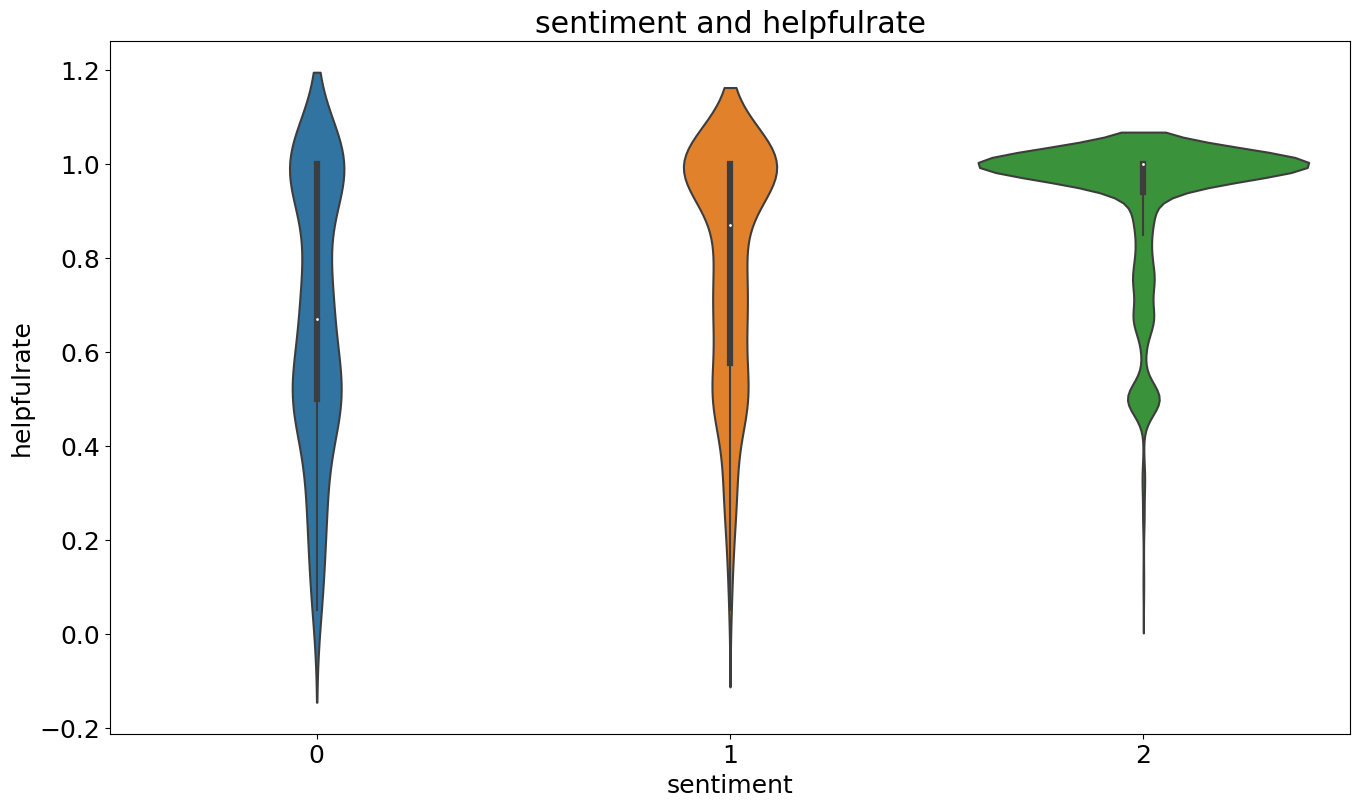

In [55]:
# 设置图形字体大小
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = 16, 9

# 创建包含情感标签和帮助率的数据框，并删除帮助率为0的记录
senti_help = pd.DataFrame(process_reviews, columns=['sentiment', 'helpful_rate'])
senti_help = senti_help[senti_help['helpful_rate'] != 0.00] 

# 绘制小提琴图
sns.violinplot(x=senti_help["sentiment"], y=senti_help["helpful_rate"])

# 设置图表标题和坐标轴标签
plt.title('sentiment and helpfulrate')
plt.xlabel('sentiment')
plt.ylabel('helpfulrate')
plt.show()

从图中我们可以看出，更多的正面评价具有较高的帮助率。

2.折线图，用于展示不同年份和情感标签的数量。横坐标表示年份，纵坐标表示情感数量，每条折线代表一个情感标签

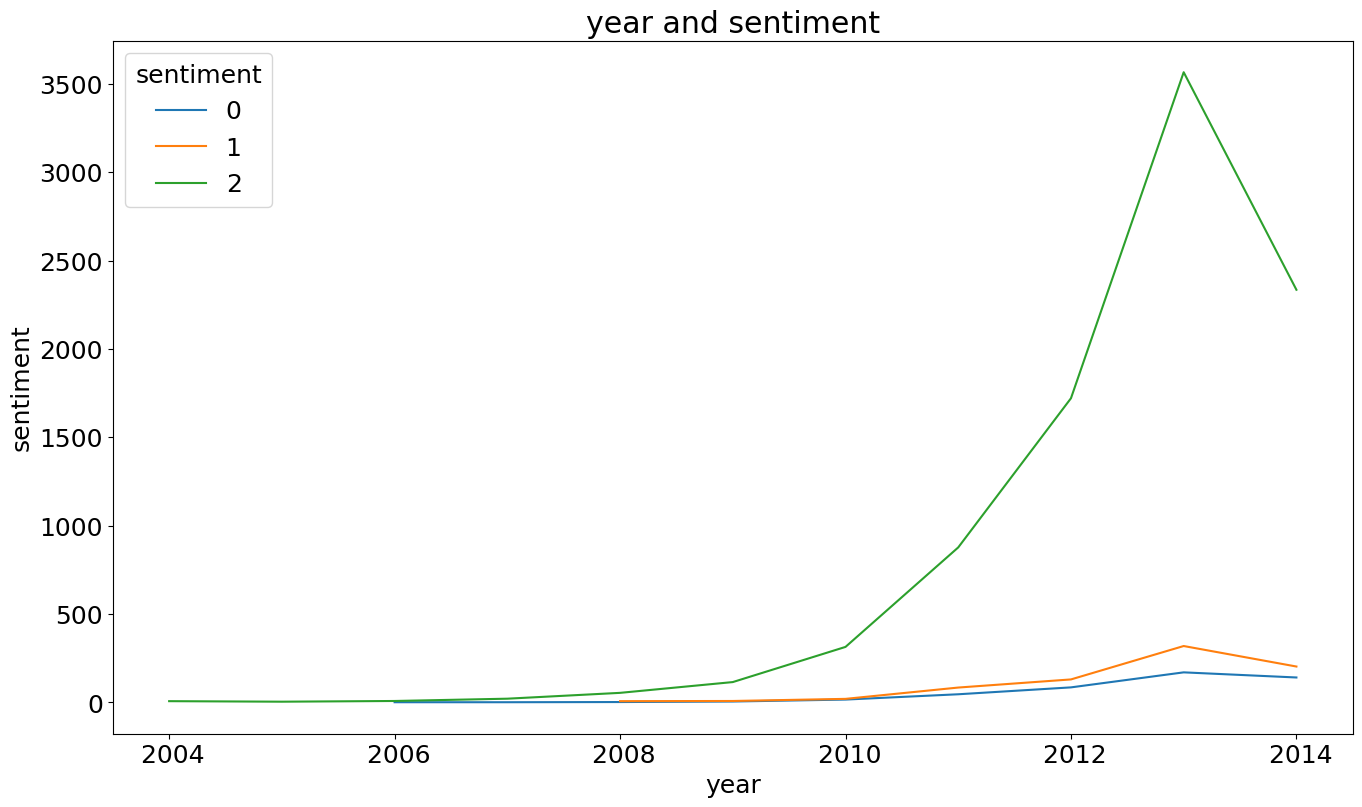

In [56]:
# 使用 groupby 操作按年份和情感标签进行分组，并计算每个分组中情感标签的数量
grouped_data = process_reviews.groupby(['year', 'sentiment'])['sentiment'].count()

# 使用 unstack 将分组结果重塑为适合绘图的形式
unstacked_data = grouped_data.unstack()

# 绘制折线图，legend=True 表示显示图例
unstacked_data.plot(legend=True)

# 设置图表标题和坐标轴标签
plt.title('year and sentiment')
plt.xlabel('year')
plt.ylabel('sentiment')

# 显示图形
plt.show()


从情节中我们可以清楚地看到，自2010年以来，正面评价的上升。2013年左右达到峰值，2014年有所下降，此时所有审查率都有所下降。与正面评价相比，负面评价和中性评价非常低

3.条形图，用于展示每天的评论数量。横坐标表示日期，纵坐标表示评论数量。

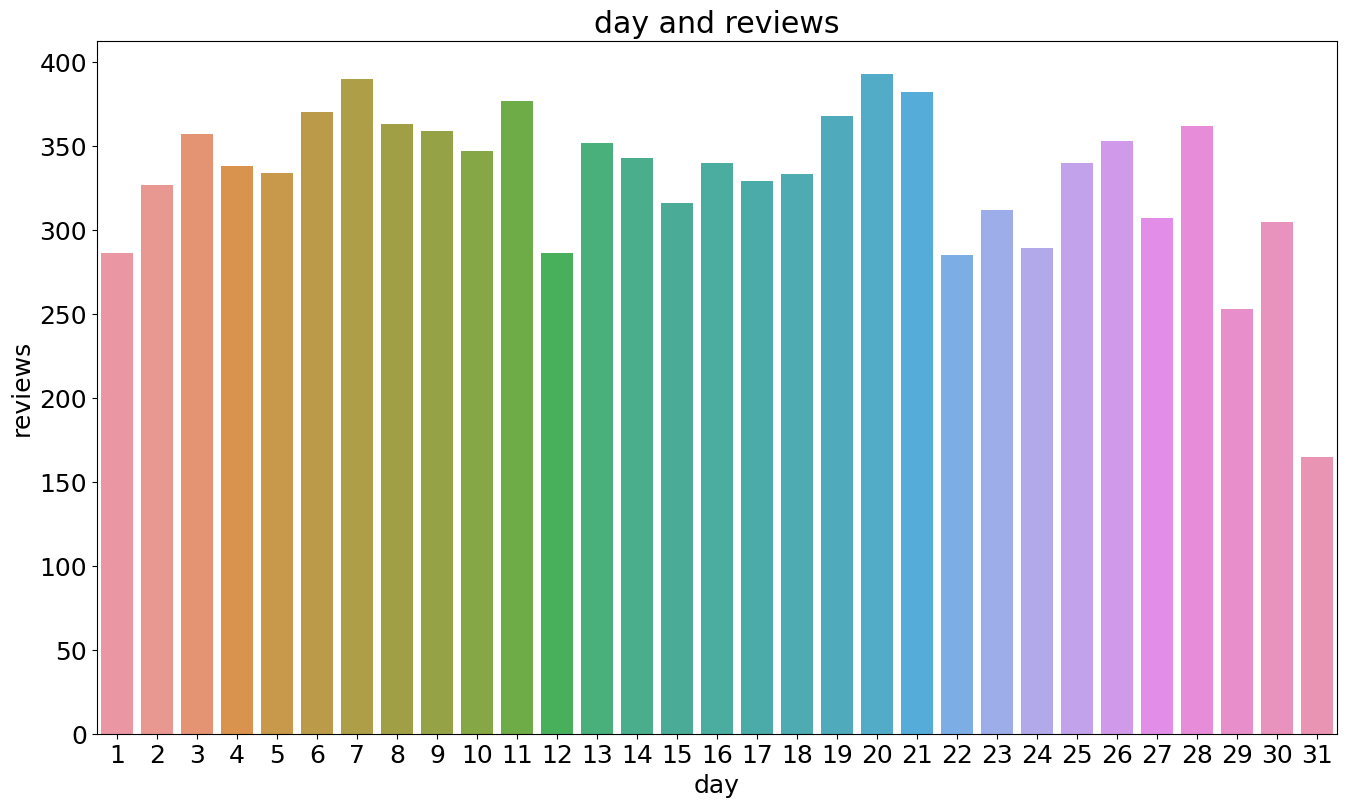

In [57]:
# 使用 groupby 操作按日期（day）进行分组，并统计每天的评论数量
day = pd.DataFrame(process_reviews.groupby('day')['reviews'].count()).reset_index()

# 将 'day' 列转换为 int64 类型，并按日期排序
day['day'] = day['day'].astype('int64')
day.sort_values(by=['day'])

# 使用条形图绘制每天的评论数量
sns.barplot(x="day", y="reviews", data=day)

# 设置图表标题和坐标轴标签
plt.title('day and reviews')
plt.xlabel('day')
plt.ylabel('reviews')

# 显示图形
plt.show()

审查次数或多或少是均匀分布的。这几天之间没有太大的差异。但在月底有一个巨大的下降。

4.情绪极性分布

In [41]:
# 初始化 Plotly 的离线模式
py.init_notebook_mode(connected=True)

# 创建直方图对象
data = [go.Histogram(x=process_reviews['polarity'], nbinsx=50)]

# 定义布局
layout = go.Layout(
    title='Sentiment Polarity Distribution',
    xaxis=dict(title='polarity'),
    yaxis=dict(title='count'),
    bargap=0.1,
    bargroupgap=0.1
)

# 绘制图表
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

与负极性相比，我们有很多正极性
这种极性分布确保了我们获得的正面评价的数量
我们可以说，这个极性是正态分布的，但不是标准的正态

5.评审评分分布

In [42]:
# 创建直方图对象
data = [go.Histogram(x=process_reviews['overall'])]

# 设置布局
layout = go.Layout(
    title='Review Rating Distribution',
    xaxis=dict(title='rating'),
    yaxis=dict(title='count'),
    bargap=0.1,
    bargroupgap=0.1
)

# 绘制图表
fig = go.Figure(data=data, layout=layout)
iplot(fig)

我们有大量的5个评级（近7k），其次是4,3,2,1。它本质上是线性的

6.文本长度分布

In [43]:

# 创建直方图对象
data = [go.Histogram(x=process_reviews['review_len'], nbinsx=100)]

# 设置布局
layout = go.Layout(
    title='Review Text Length Distribution',
    xaxis=dict(title='review length'),
    yaxis=dict(title='count'),
    bargap=0.1,
    bargroupgap=0.1
)

# 绘制图表
fig = go.Figure(data=data, layout=layout)
iplot(fig)

我们有一个右偏分布，其中大多数长度在0-1000之间

7.文本字数分布

In [44]:
# 创建直方图对象
data = [go.Histogram(x=process_reviews['word_count'], nbinsx=100)]

# 设置布局
layout = go.Layout(
    title='Review Text Word Count Distribution',
    xaxis=dict(title='word count'),
    yaxis=dict(title='count'),
    bargap=0.1,
    bargroupgap=0.1
)

# 绘制图表
fig = go.Figure(data=data, layout=layout)
iplot(fig)

我们有一个右偏分布，在一篇综述中，大多数单词都在0-200之间

8.不同评分的评论所占的百分比

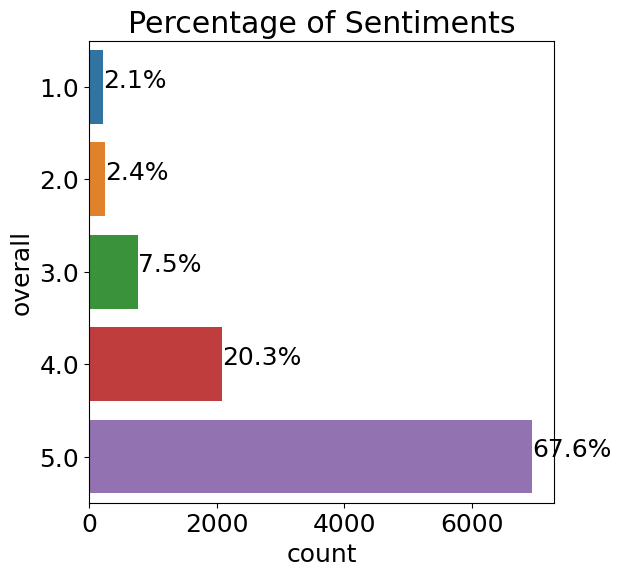

In [45]:
plt.figure(figsize=(6,6))
plt.title('Percentage of Sentiments')
ax = sns.countplot(y = 'overall', data = process_reviews)
total = len(process_reviews)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

9.一个包含三个子图的图表，分别显示了积极、中立和消极评论中最常见的单词。

In [46]:
## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in stop_words]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace


In [47]:
print("Number of positive reviews:", len(review_pos))
print("Number of neutral reviews:", len(review_neu))
print("Number of negative reviews:", len(review_neg))

# 或者检查 DataFrame 的前几行数据
print("Positive reviews sample:")
print(review_pos.head())

print("Neutral reviews sample:")
print(review_neu.head())

print("Negative reviews sample:")
print(review_neg.head())


Number of positive reviews: 8998
Number of neutral reviews: 771
Number of negative reviews: 465
Positive reviews sample:
       reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime   reviewTime  \
0      1393545600  02 28, 2014   
1      1363392000  03 16, 2013   
2      1377648000  08 28, 2013   
3      1392336000  02 14, 2014   
4      1392940800  02 21, 2014   

                              

In [48]:
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')
import plotly.tools as tools
# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of neutral reviews",
                                          "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

正如我们所看到的，只有少数几个词与情感不符。我们不能根据一个词来判断一种情调。所以让我们试着用频繁的两个词

10.二元分析
在这里，我们将根据情感绘制评论中最常见的两个词

In [49]:
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent, 2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(20), 'blue')


## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent, 2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(20), 'purple')


## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent, 2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(20), 'yellow')
# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing = 0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of neutral reviews",
                                          "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

11.三角图分析
在这里，我们将根据情感绘制评论中最常见的三个词

In [50]:
## Get the bar chart from positive reviews ##
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')




# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04, horizontal_spacing=0.05,
                          subplot_titles=["Tri-gram plots of Positive reviews", 
                                          "Tri-gram plots of Neutral reviews",
                                          "Tri-gram plots of Negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
iplot(fig, filename='word-plots')

12.积极评价词云图

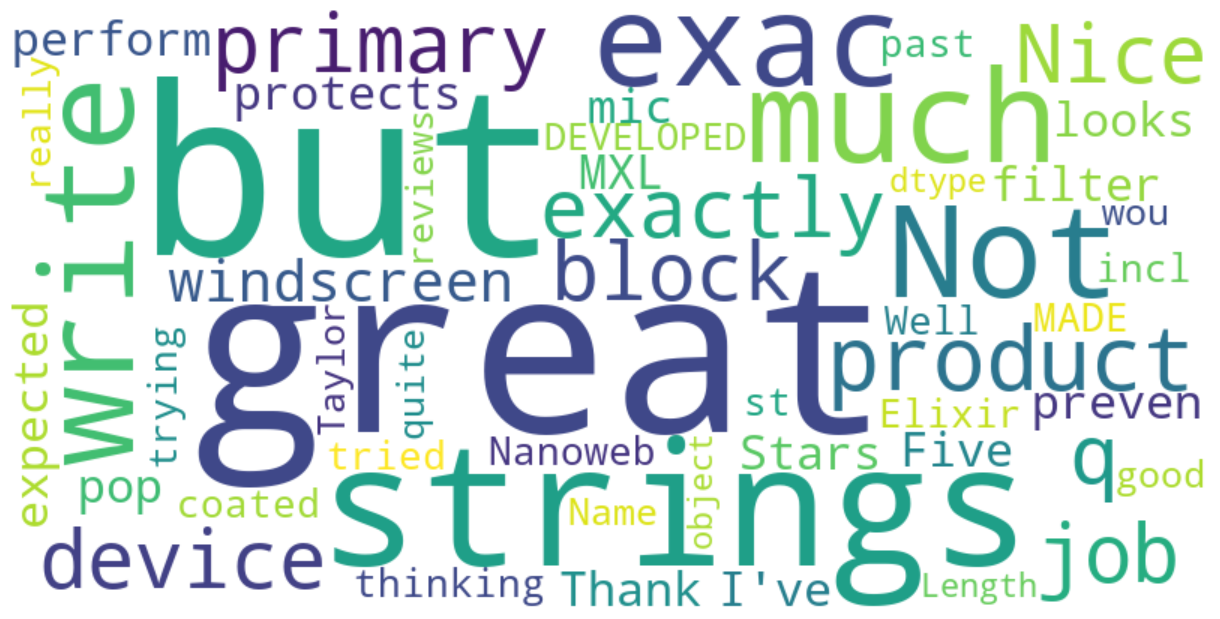

In [53]:
text = review_pos["reviews"]
# 定义词云参数
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',  # 背景颜色
    colormap='viridis',         # 颜色映射
    max_words=100,              # 最大词数
    stopwords=stop_words,       # 停用词
    contour_color='steelblue',  # 轮廓颜色
    contour_width=2,            # 轮廓宽度
    random_state=42             # 随机种子，确保每次生成结果一致
).generate(str(text))

# 显示词云
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 不显示坐标轴
plt.tight_layout(pad=0)
plt.show()

13.中性评论的词云图

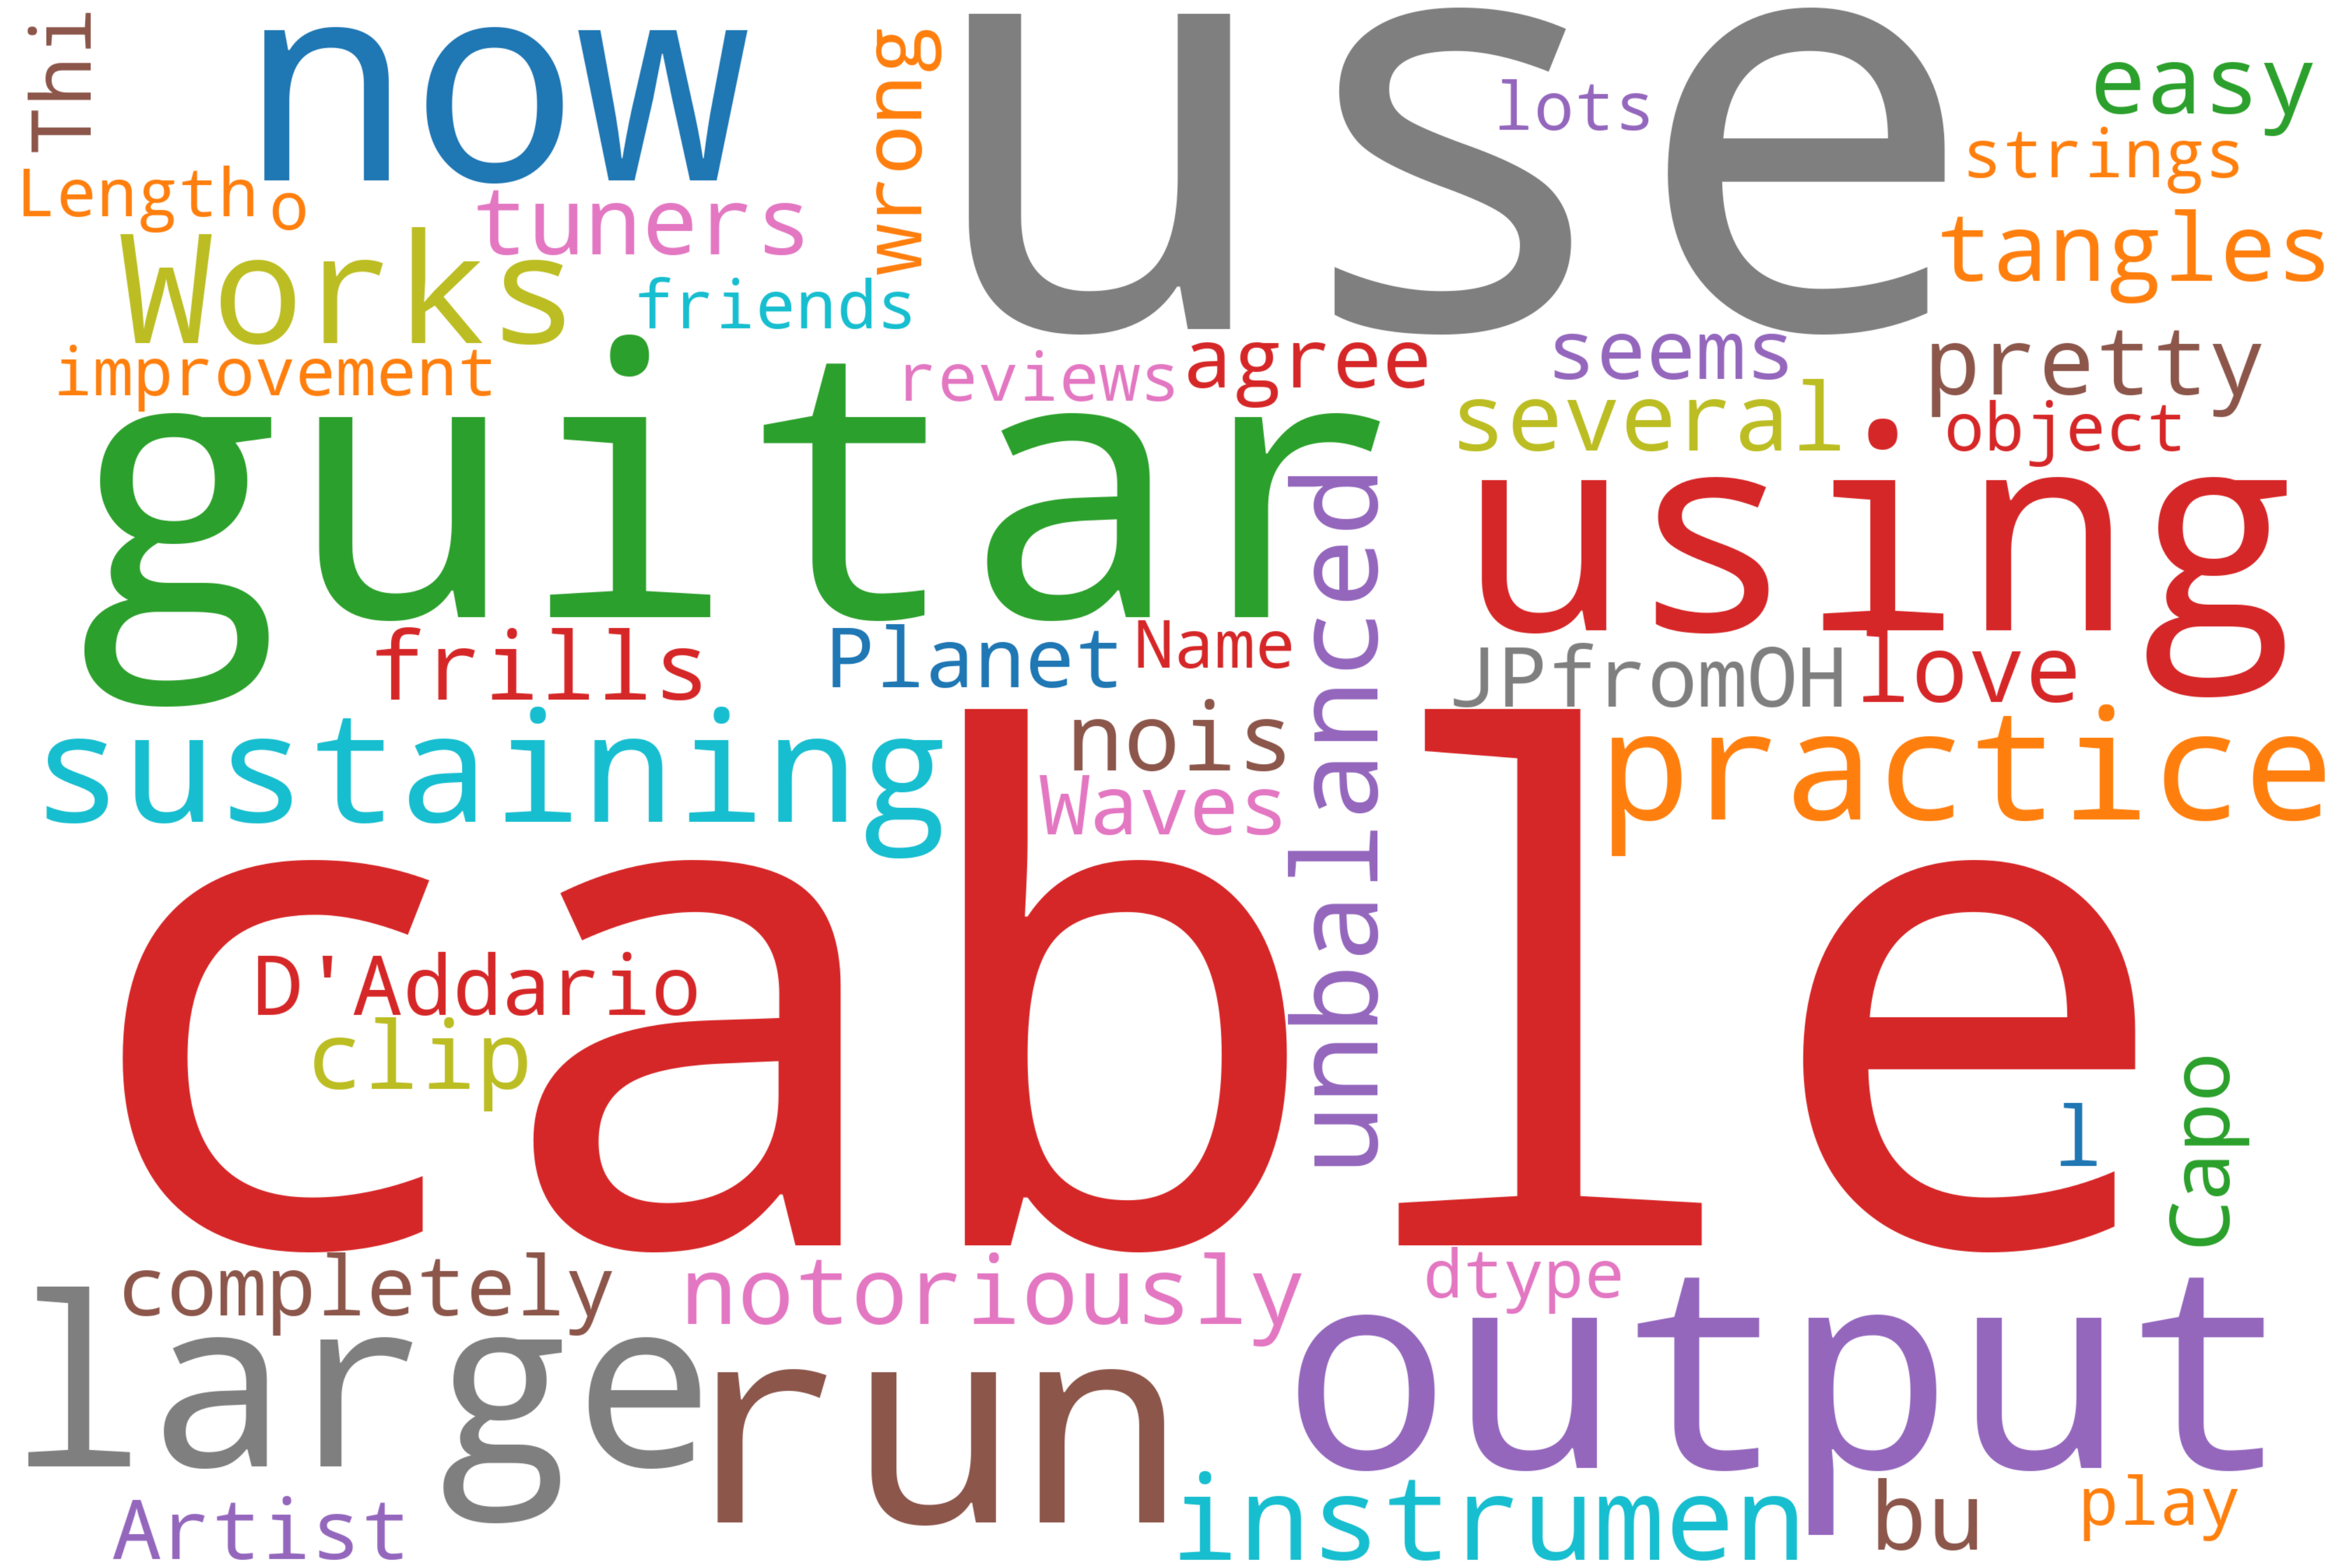

In [ ]:
# 生成词云
wordcloud = WordCloud(
    width=3000,
    height=2000,
    background_color='white',  # 更改背景颜色为白色
    colormap='tab10',  # 使用不同的颜色
    stopwords=STOPWORDS
).generate(str(text))

# 显示词云
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


14.消极评论词云图

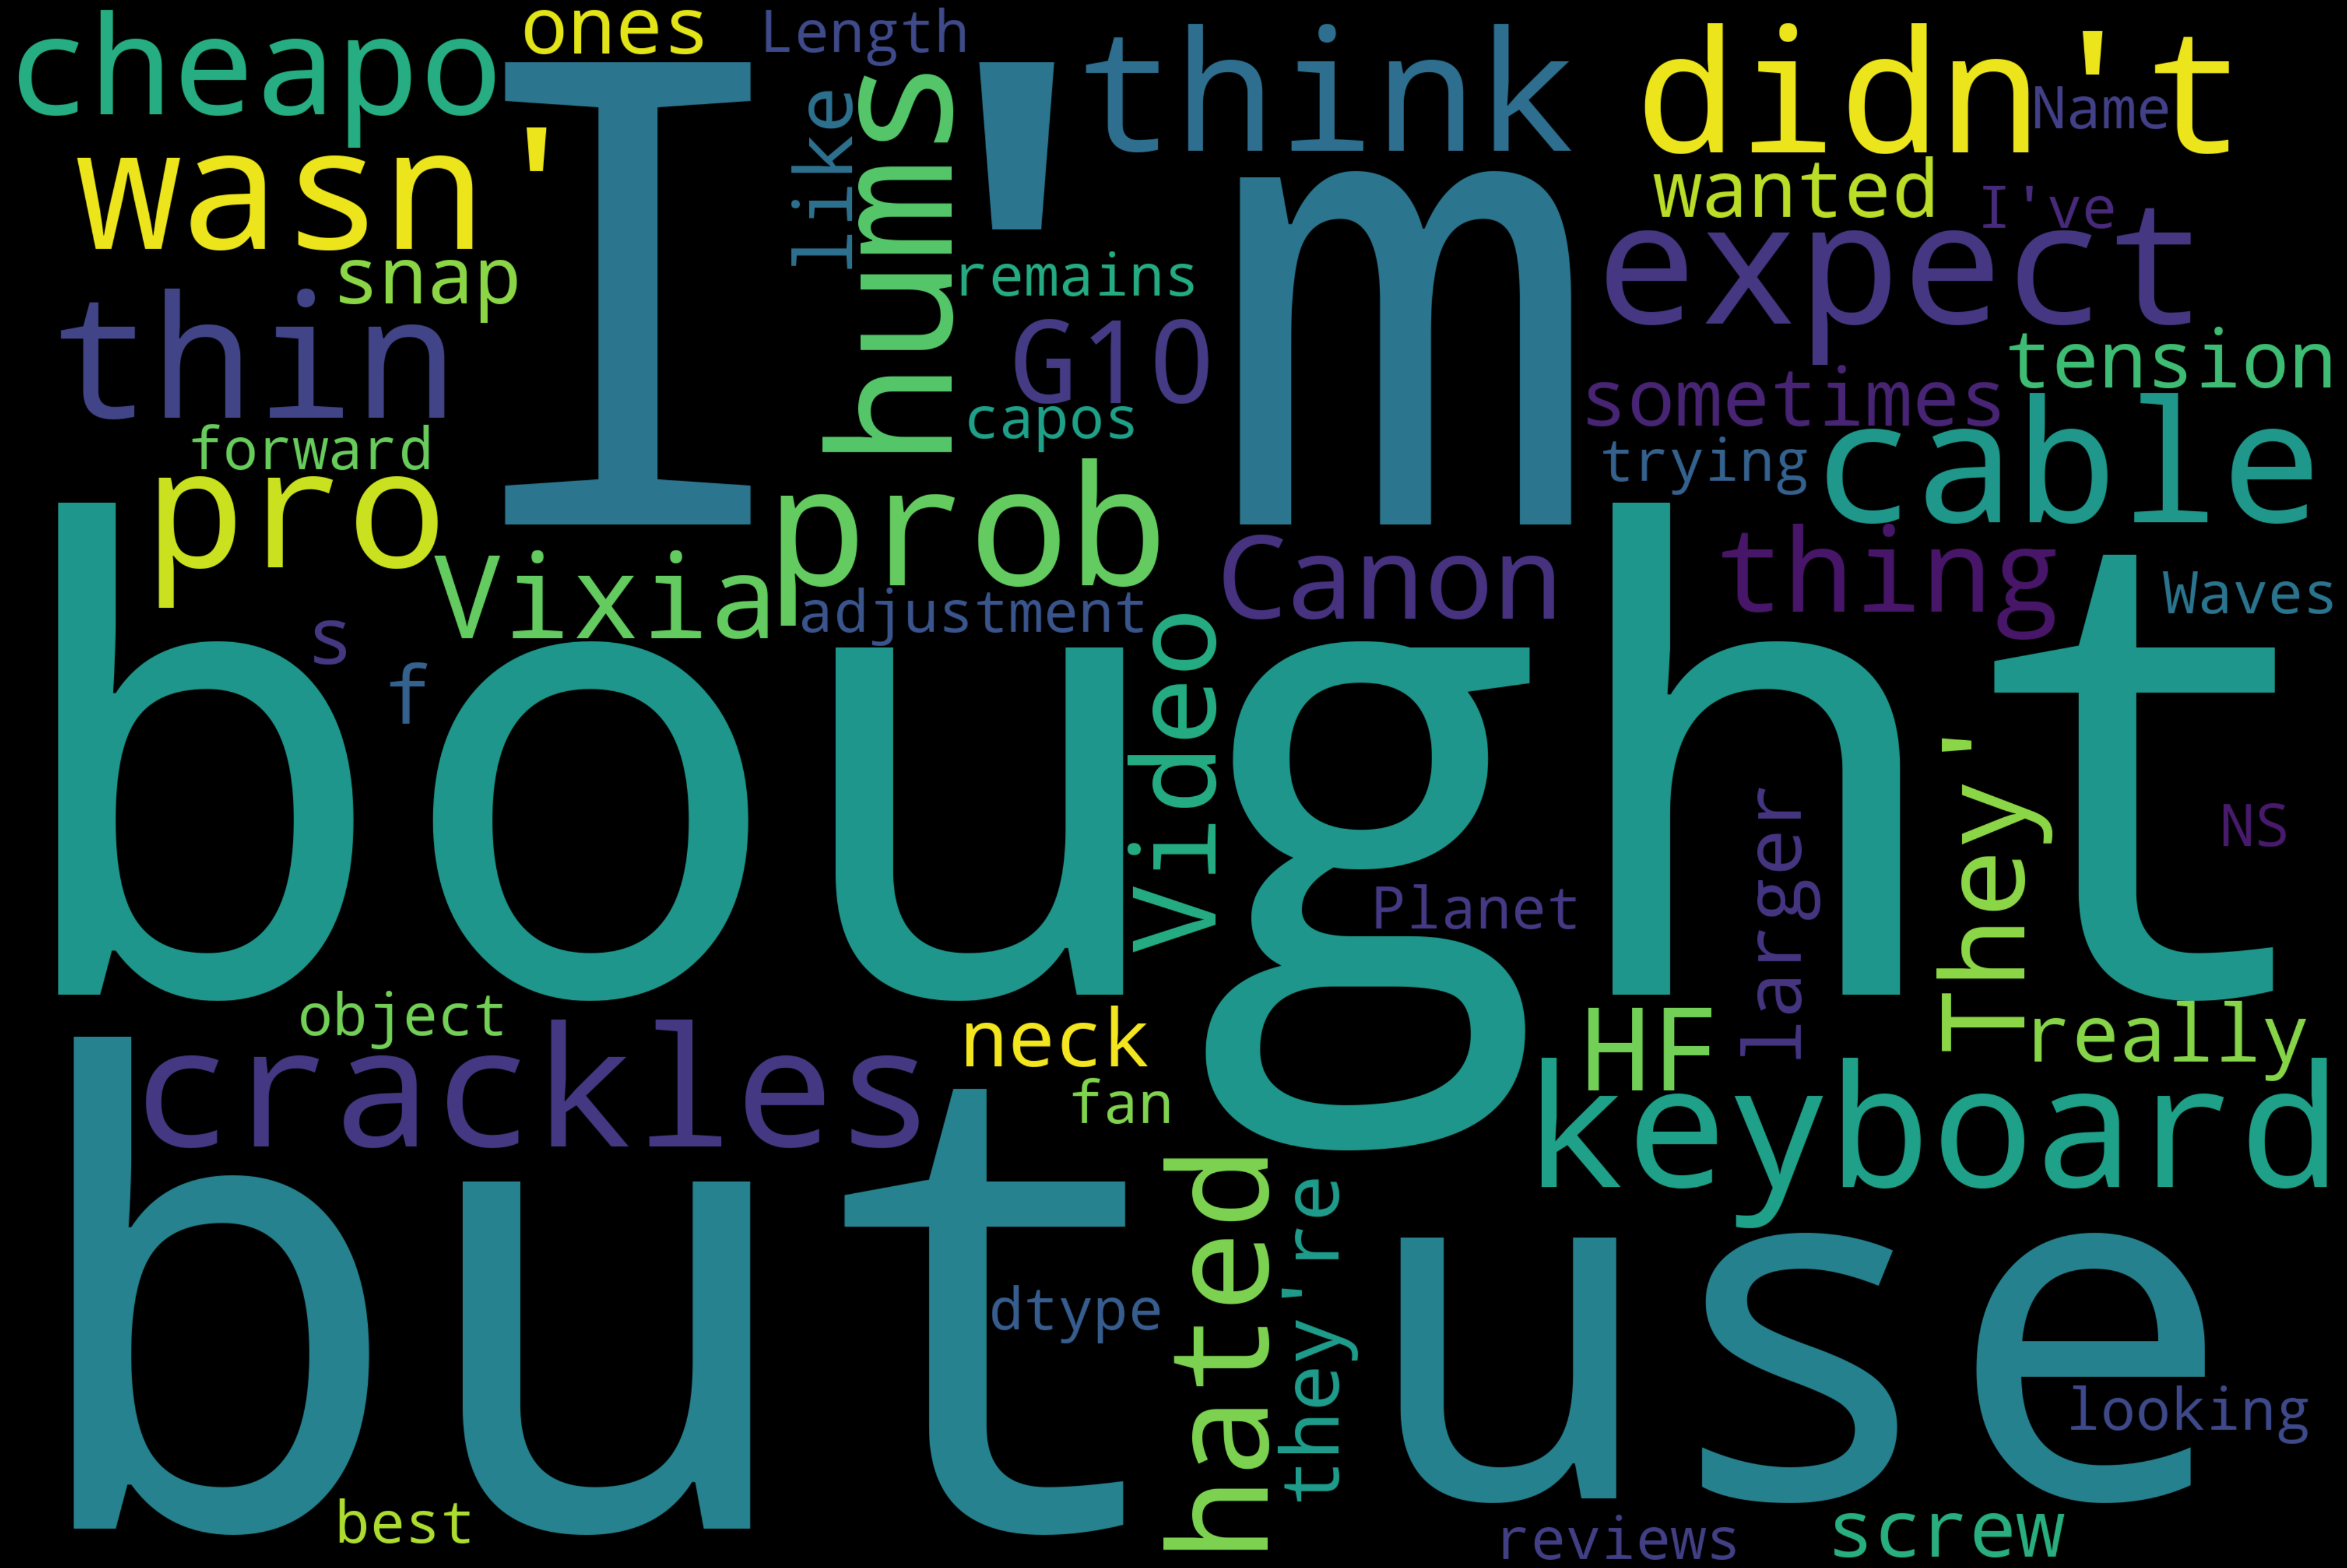

In [ ]:
text = review_neg["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stop_words).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

15.包含多个变量的雷达图

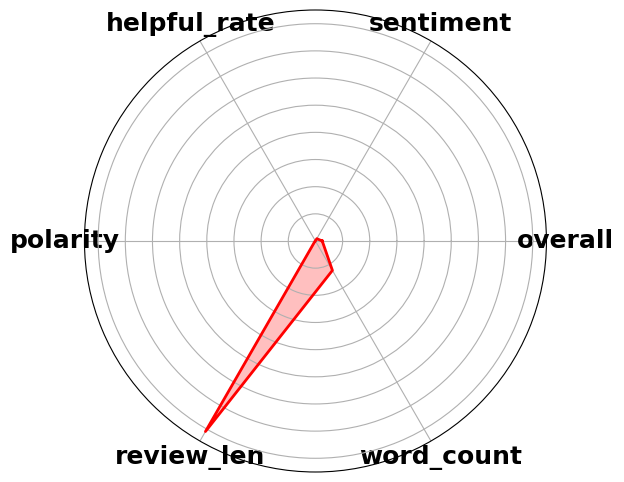

In [ ]:
# 定义变量标签
labels=np.array(['overall', 'sentiment', 'helpful_rate', 'polarity', 'review_len', 'word_count'])

# 定义变量的值
stats=np.array([5.0, 2, 0.00, 0.25, 162, 25])

# 绘制雷达图
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()

stats=np.concatenate((stats,[stats[0]]))
angles=np.concatenate((angles,[angles[0]]))

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, stats, color='red', alpha=0.25)
ax.plot(angles, stats, color='red', linewidth=2)

# 添加标签
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontweight='bold')

plt.show()


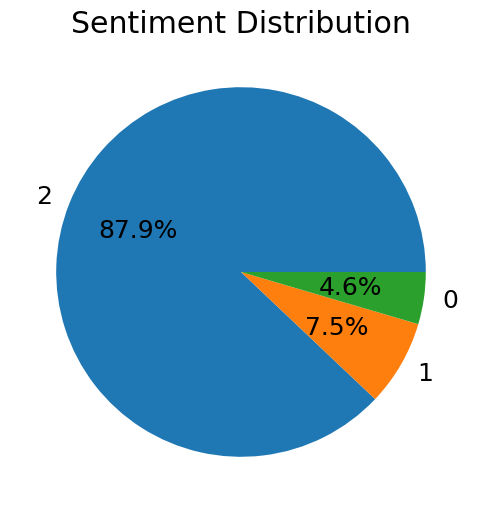

In [ ]:
# import the matplotlib library to create visualizations
import matplotlib.pyplot as plt

# count the number of occurrences of each sentiment value in the 'sentiment' column and store the results in 'sentiment_counts'
sentiment_counts = process_reviews['sentiment'].value_counts()

# create a pie chart of the 'sentiment_counts' data using the 'pie' function, with labels and percentage values
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')

# set the title of the plot to 'Sentiment Distribution'
plt.title('Sentiment Distribution')

# display the plot
plt.show()


---------------------------------------------------------------------------------------------------------------------------------------------

传统机器学习算法比较


建立逻辑回归模型


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
X= tfidf_vectorizer.fit_transform(review_features['reviews'])
y=process_reviews['sentiment']

In [ ]:
logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
knn_cv=KNeighborsClassifier()
svc_cv=SVC()
nb_cv=BernoulliNB()
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'SVC',4:'Naive Bayes'}
cv_models=[logreg_cv,dt_cv,knn_cv,svc_cv,nb_cv]
#执行交叉验证并打印结果
for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.8810059200798708
Decision Tree Test Accuracy: 0.8141516292082581
KNN Test Accuracy: 0.8790565074375868
SVC Test Accuracy: 0.8795439317757772
Naive Bayes Test Accuracy: 0.8038184420263036


In [ ]:
param_grid = {'C': np.logspace(-4, 4, 50),
             'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state=0), param_grid,cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

LogisticRegression(C=6866.488450042998, random_state=0)
The mean accuracy of the model is: 0.9364563322003843


In [ ]:
logreg = LogisticRegression(C=10000.0, random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.94


Confusion matrix, without normalization


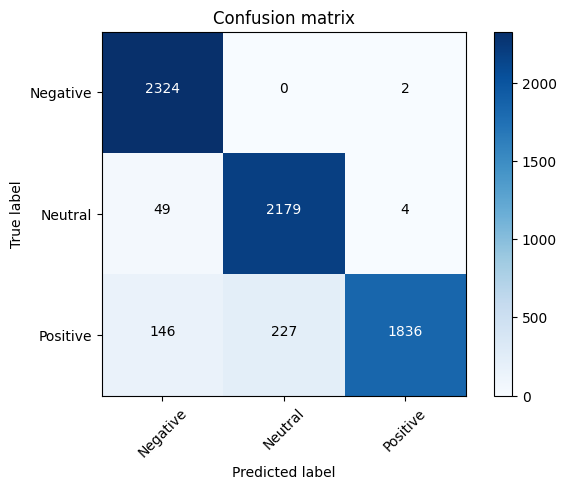

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'])

In [ ]:
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      2326
           1       0.91      0.98      0.94      2232
           2       1.00      0.83      0.91      2209

    accuracy                           0.94      6767
   macro avg       0.94      0.94      0.94      6767
weighted avg       0.94      0.94      0.94      6767



In [ ]:
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

#Train-Test split(80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=10))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=4,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

建立 KNN 模型


In [ ]:
y_train = y_train.ravel()
#交叉验证法选排 k 值
from sklearn import neighbors 
from sklearn import datasets 
from sklearn.model_selection import cross_val_score 
for k in range (1,20,1):
#执行 K 近邻算法
   knn=neighbors.KNeighborsClassifier(n_neighbors=k)
#5折交叉验证
   scores = cross_val_score(knn, X_res, y_res,cv=4)
   print(f'K ={k}: the mean score is {100*scores.mean():.2f}%.')

K =1: the mean score is 68.37%.
K =2: the mean score is 64.91%.
K =3: the mean score is 64.83%.
K =4: the mean score is 63.20%.
K =5: the mean score is 63.21%.
K =6: the mean score is 61.90%.
K =7: the mean score is 62.27%.
K =8: the mean score is 61.24%.
K =9: the mean score is 61.21%.
K =10: the mean score is 59.91%.
K =11: the mean score is 60.18%.
K =12: the mean score is 59.07%.
K =13: the mean score is 59.41%.
K =14: the mean score is 58.20%.
K =15: the mean score is 58.27%.
K =16: the mean score is 57.11%.
K =17: the mean score is 57.37%.
K =18: the mean score is 56.09%.
K =19: the mean score is 56.54%.


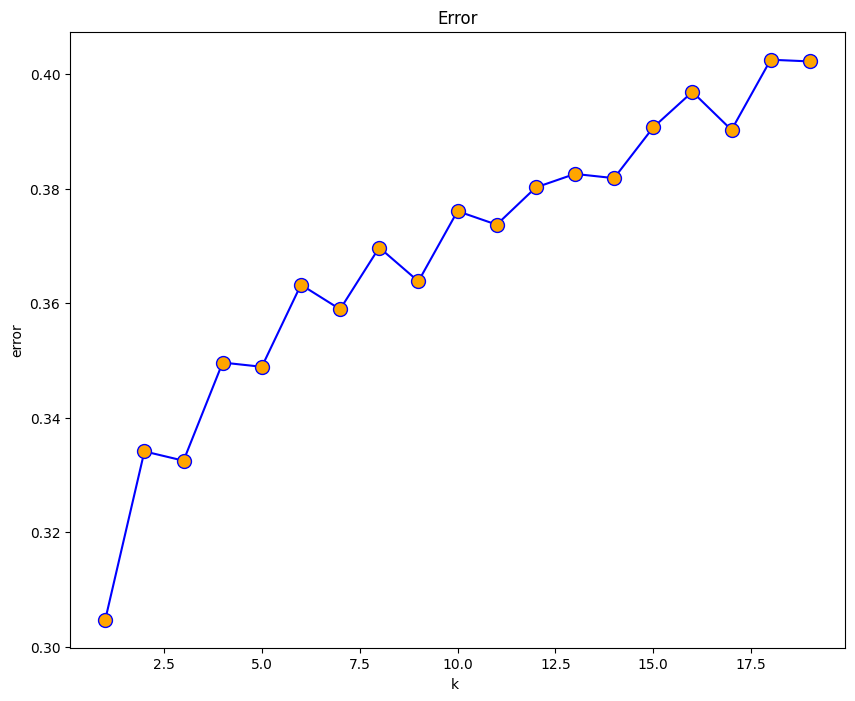

In [ ]:
#获取最优的超参数
erros = []
for k in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=k)
       # 使用训练集进行训练
    knn.fit(X_train, y_train)
    # 对测试集进行预测
    pred_i = knn.predict(X_test)
    # 计算并存储误差
    erros.append(np.mean(pred_i != y_test))

# 绘制误差曲线
plt.figure(figsize=(10, 8))
plt.plot(range(1, 20), erros, color='blue', marker='o', markerfacecolor='orange', markersize=10)
plt.title('Error')
plt.xlabel('k ')
plt.ylabel('error')
plt.show()

In [ ]:
#k=1时，误差最小
knn=KNeighborsClassifier(n_neighbors= 1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
#混淆矩阵
def plot_confusion_matrix(cm,target_names,title='Confusion Matrix',camp=None,normalize=False):
    import itertools
    accuracy = np.trace(cm)/float(np.sum(cm))
    misclass = 1-accuracy
    if camp is None:
        camp=plt.get_cmap('Oranges')

    plt.figure(figsize=(8,5))
    plt.imshow(cm, interpolation='nearest', cmap=camp)
    plt.title("Confusion Matrix")
    plt.colorbar()
    if target_names is None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=15)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    thresh = cm.max()/1.5 if normalize else cm.max() / 2
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment='center',
                     color="white" if cm[i,j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment='center',
                     color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f};misclass={:0.4f}'.format(accuracy, misclass))

In [ ]:
#计算混淆矩阵指标
from sklearn.metrics import confusion_matrix
y_pred=knn.predict(X_test)
conf_mx = confusion_matrix(y_test, y_pred)
TN = conf_mx[0, 0]
FP = conf_mx[0, 1]
FN = conf_mx[1, 0]
TP = conf_mx[1, 1]
print("TN:", TN)
print("FP:", FP)
print("FN:", FN)
print("TP:", TP)

TN: 2201
FP: 26
FN: 48
TP: 2136


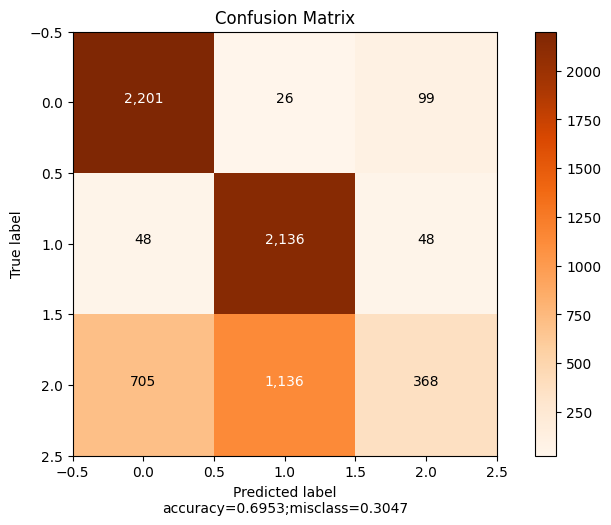

In [ ]:
plot_confusion_matrix(conf_mx, normalize = False, target_names=['0','1'])
plt.show()

朴素贝叶斯模型


In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)

MultinomialNB()

In [ ]:
nb_pred = nb_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
def evaluation(name, y_test, nb_pred):
    cm = confusion_matrix(y_test, nb_pred)
    t1 = ConfusionMatrixDisplay(cm)
    print("Classification Report for Naive Bayes: \n")
    print(classification_report(y_test, nb_pred))
    t1.plot()

Classification Report for Naive Bayes: 

              precision    recall  f1-score   support

           0       0.87      0.94      0.91      2326
           1       0.83      0.89      0.86      2232
           2       0.87      0.74      0.80      2209

    accuracy                           0.86      6767
   macro avg       0.86      0.86      0.85      6767
weighted avg       0.86      0.86      0.86      6767



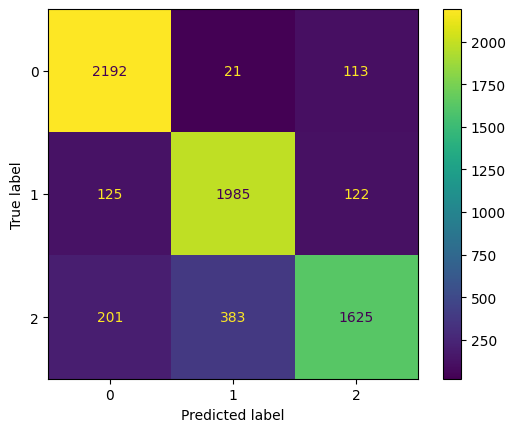

In [ ]:
evaluation('Classification', y_test, nb_pred)